In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from glob import glob
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/distraction dataset/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df.shape

(22424, 3)

In [ ]:
# Groupby subjects
by_drivers = df.groupby('subject')
#Group unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id

print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(df.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [ ]:
num_classes = 10

In [ ]:
#Read with opencv
def get_image(path, img_rows, img_cols, color_type=3):

    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    img = cv2.flip()
    return img

#Loading training dataset
def train_data_load(img_rows=150, img_cols=150, color_type=3):
    train_images=[]
    train_labels=[]

#Loop over the training folder
    for classes in tqdm(range(num_classes)):
        print('Loading directory c{}'.format(classes))
        files = glob(os.path.join('/content/drive/MyDrive/data/distraction dataset/train/c' + str(classes), '*.jpg'))
#         files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classes), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classes)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = train_data_load(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)

    return x_train, x_test, y_train, y_test


In [ ]:
#Loading validation dataset
def load_test(size=200000, img_rows=150, img_cols=150, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('/content/drive/MyDrive/data/distraction dataset/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id


In [ ]:
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [ ]:
pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 594 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56460 sha256=e14214fbc713b71896e068dc029574d56c91e0be1c717558573f2a2f42113f31
  Stored in directory: /root/.cache/pip/wheels/55/8b/e7/a23fd46c709c21e3e6fcb55978d88b018f80d54018459978c3
Successfully built np-utils


In [ ]:
img_rows = 150
img_cols = 150
color_type = 3
nb_test_samples = 200

#Loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

#Loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:23<03:30, 23.41s/it]

Loading directory c1


 20%|██        | 2/10 [01:30<06:32, 49.09s/it]

Loading directory c2


 30%|███       | 3/10 [02:27<06:10, 52.86s/it]

Loading directory c3


 40%|████      | 4/10 [03:16<05:07, 51.24s/it]

Loading directory c4


 50%|█████     | 5/10 [04:15<04:30, 54.09s/it]

Loading directory c5


 60%|██████    | 6/10 [05:24<03:56, 59.18s/it]

Loading directory c6


 70%|███████   | 7/10 [06:27<03:00, 60.31s/it]

Loading directory c7


 80%|████████  | 8/10 [07:14<01:52, 56.19s/it]

Loading directory c8


 90%|█████████ | 9/10 [07:58<00:52, 52.38s/it]

Loading directory c9


 13%|█▎        | 200/1555 [00:21<02:25,  9.31it/s]


## Data Visualisation

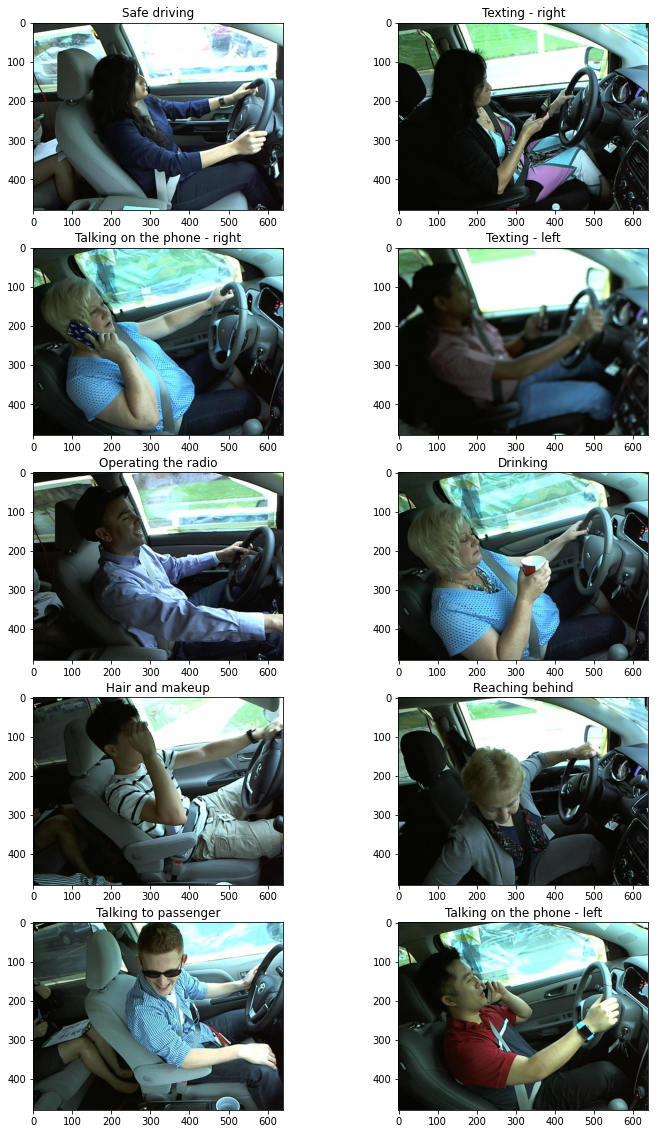

In [ ]:
driver_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

plt.figure(figsize = (12, 20))
image_count = 1

BASE_URL = '/content/drive/MyDrive/data/distraction dataset/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(driver_map[directory])


## Model Architecture - VGG-16

In [ ]:
batch_size = 40
n_epochs = 10

In [ ]:
from keras.layers import Input
vgg16_input = Input(shape = (150, 150, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(inputs = vgg16_input, outputs = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = tf.keras.optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 predictions (Dense)         (None, 10)                81930     
                                                                 
Total params: 14,796,618
Trainable params: 14,796,618
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = vgg16_pretrained.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=n_epochs, batch_size=batch_size, verbose=1)
print('History of the training',history.history)

Epoch 1/10
408/408 [==============================] - 142s 314ms/step - loss: 0.7788 - accuracy: 0.7777 - val_loss: 23.0182 - val_accuracy: 0.1100
Epoch 2/10
408/408 [==============================] - 132s 323ms/step - loss: 0.4417 - accuracy: 0.8737 - val_loss: 0.0721 - val_accuracy: 0.9791
Epoch 3/10
408/408 [==============================] - 145s 356ms/step - loss: 0.0381 - accuracy: 0.9902 - val_loss: 0.0587 - val_accuracy: 0.9835
Epoch 4/10
408/408 [==============================] - 136s 334ms/step - loss: 0.0104 - accuracy: 0.9975 - val_loss: 0.0716 - val_accuracy: 0.9823
Epoch 5/10
408/408 [==============================] - 136s 333ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.0441 - val_accuracy: 0.9904
Epoch 6/10
408/408 [==============================] - 137s 336ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0400 - val_accuracy: 0.9919
Epoch 7/10
408/408 [==============================] - 136s 335ms/step - loss: 5.2295e-04 - accuracy: 1.0000 - val_loss: 0.0

In [ ]:
vgg16_pretrained.save("vgg16_model.h5")

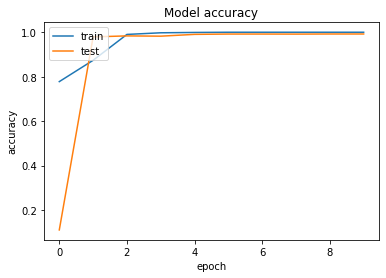

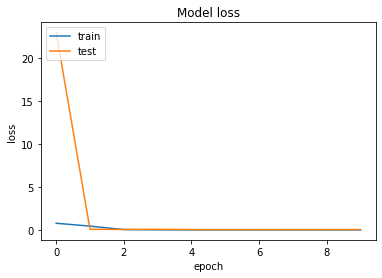

In [ ]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=3):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(driver_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

In [ ]:
score1 = vgg16_pretrained.evaluate(x_test, y_test, verbose=1)

128/128 [==============================] - 12s 84ms/step - loss: 0.0436 - accuracy: 0.9921


In [ ]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.04361744225025177
Accuracy:  99.21395182609558  %


1/1 [==============================] - 1s 754ms/step
Y prediction: [[6.24916447e-06 9.96226799e-12 1.11607965e-02 2.46292875e-09
  1.12797283e-08 9.87085521e-01 1.60561541e-07 2.41270026e-08
  1.73254241e-03 1.46634047e-05]]
Predicted: Operating the radio


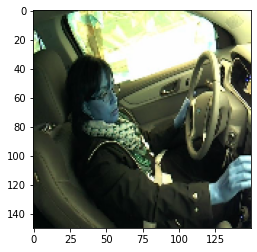

1/1 [==============================] - 0s 16ms/step
Y prediction: [[7.1443104e-15 5.9654169e-25 1.5530017e-22 2.6802211e-18 7.7913618e-17
  1.0000000e+00 6.1167775e-22 1.4628635e-19 8.2930516e-14 5.2894269e-16]]
Predicted: Operating the radio


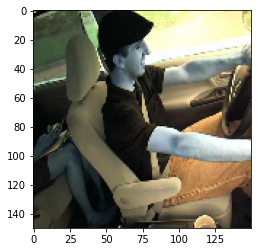

1/1 [==============================] - 0s 18ms/step
Y prediction: [[9.9660444e-01 2.0092984e-06 5.0592117e-09 1.4290749e-06 3.3035071e-06
  1.4815682e-03 1.6851427e-11 1.1728621e-03 2.2963964e-04 5.0470664e-04]]
Predicted: Safe driving


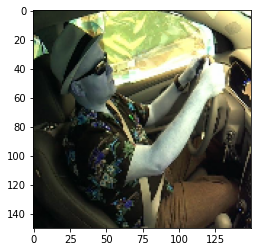

1/1 [==============================] - 0s 16ms/step
Y prediction: [[4.8901615e-18 1.8671824e-17 7.2844410e-15 1.6522194e-18 2.2194521e-15
  6.4764198e-15 1.8973824e-17 5.4918920e-17 1.0000000e+00 5.0312954e-10]]
Predicted: Hair and makeup


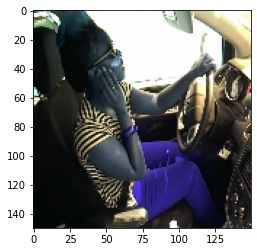

1/1 [==============================] - 0s 18ms/step
Y prediction: [[2.2553971e-11 1.2711843e-21 1.2613454e-20 3.7420335e-16 3.0729625e-16
  1.0000000e+00 3.8275752e-23 4.1271602e-18 7.5911987e-14 4.4010724e-14]]
Predicted: Operating the radio


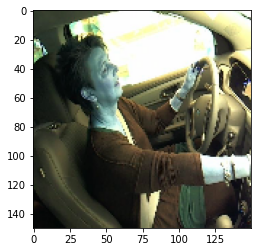

1/1 [==============================] - 0s 17ms/step
Y prediction: [[6.4440281e-10 1.8080050e-15 2.3105589e-12 2.2004698e-12 1.0216635e-12
  9.9987769e-01 4.0922200e-23 1.2755229e-08 6.2972813e-06 1.1595730e-04]]
Predicted: Operating the radio


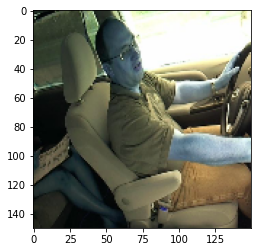

1/1 [==============================] - 0s 17ms/step
Y prediction: [[2.2225910e-09 3.0575542e-08 4.8040403e-07 9.1176476e-11 6.3771370e-11
  5.2277016e-11 9.9989784e-01 5.7457882e-08 1.0135906e-04 2.7416979e-07]]
Predicted: Drinking


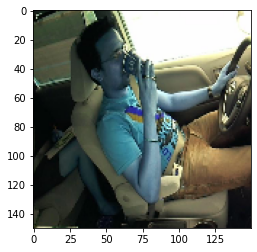

1/1 [==============================] - 0s 19ms/step
Y prediction: [[1.3400263e-17 9.2166544e-15 4.2359305e-16 1.2576142e-17 1.6332881e-18
  2.0098085e-16 1.6879470e-09 9.7865790e-18 1.0000000e+00 1.0277012e-08]]
Predicted: Hair and makeup


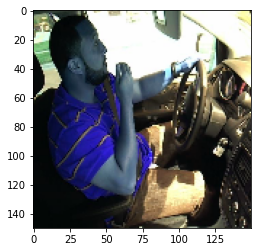

1/1 [==============================] - 0s 18ms/step
Y prediction: [[6.6033498e-11 9.4436234e-01 4.4721826e-16 5.5637650e-02 5.4546132e-09
  1.9599533e-14 3.5172565e-14 5.2800753e-11 3.1184996e-11 5.6464162e-09]]
Predicted: Texting - right


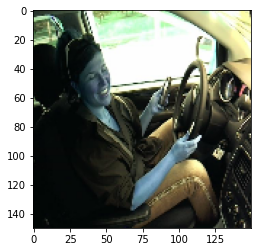

1/1 [==============================] - 0s 19ms/step
Y prediction: [[8.6459806e-12 3.5408702e-25 2.0413631e-18 1.4350372e-15 8.0365394e-17
  1.0000000e+00 3.1666625e-25 5.9518716e-17 5.3203166e-09 3.9514825e-10]]
Predicted: Operating the radio


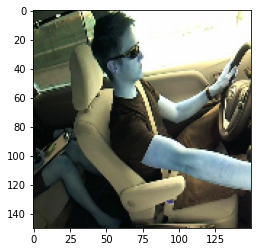

In [ ]:
for i in range(10):
    plot_test_class(vgg16_pretrained, test_files, i)

#VGG 16 using Image Augmentation

In [ ]:
#using image generator

train_gen  = ImageDataGenerator(rescale = 1.0/255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                   validation_split = 0.2)

test_gen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.2)


In [ ]:
nb_train_samples = 408
nb_validation_samples = 408
training_generator = train_gen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_gen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
history_v2 = vgg16_pretrained.fit(training_generator,
                         steps_per_epoch = nb_train_samples,
                         epochs = n_epochs,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_train_samples)

Epoch 1/10
408/408 [==============================] - ETA: 0s - loss: 1.3036 - accuracy: 0.5864

408/408 [==============================] - 132s 320ms/step - loss: 1.3036 - accuracy: 0.5864 - val_loss: 0.3404 - val_accuracy: 0.9177
Epoch 2/10
408/408 [==============================] - 125s 307ms/step - loss: 0.3351 - accuracy: 0.9007
Epoch 3/10
408/408 [==============================] - 127s 312ms/step - loss: 0.1812 - accuracy: 0.9484
Epoch 4/10
408/408 [==============================] - 129s 317ms/step - loss: 0.1628 - accuracy: 0.9569
Epoch 5/10
408/408 [==============================] - 128s 312ms/step - loss: 0.0909 - accuracy: 0.9733
Epoch 6/10
408/408 [==============================] - 130s 318ms/step - loss: 0.0743 - accuracy: 0.9783
Epoch 7/10
408/408 [==============================] - 127s 311ms/step - loss: 0.0547 - accuracy: 0.9844
Epoch 8/10
408/408 [==============================] - 130s 317ms/step - loss: 0.0487 - accuracy: 0.9854
Epoch 9/10
408/408 [==============================] - 128s 313ms/step - loss: 0.0454 - accuracy: 0.9879
Epoch 10/10
408/408 [============

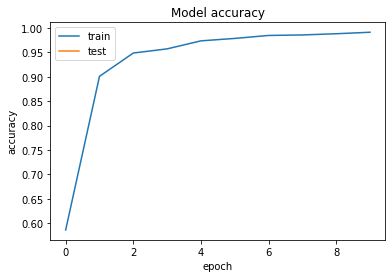

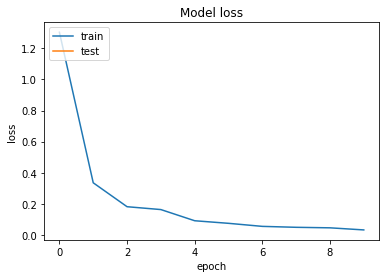

In [ ]:
plot_train_history(history_v2)

In [ ]:
score2 = vgg16_pretrained.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Loss for model 1",score1[0])
print("Loss for model 2 (data augmentation):", score2[0])

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

<ipython-input-32-9c4272940d94>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score2 = vgg16_pretrained.evaluate_generator(validation_generator, nb_validation_samples // batch_size)


Loss for model 1 0.04361744225025177
Loss for model 2 (data augmentation): 0.07111914455890656
Test accuracy for model 1 0.9921395182609558
Test accuracy for model 2 (data augmentation): 0.9800000190734863


In [ ]:
vgg16_pretrained.save("vegg16_pretrained_aug.h5")